## Recurrent Neural Networks (RNNs) for the Regression Problem

In this notebook, we build a Recurrent Neural Networks (RNNs) using GloVe word embeddings, to predict the __log_votes__ field of our review dataset.

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)

__Important note:__ One big distinction betweeen the regular neural networks and RNNs is that RNNs work with sequential data. In our case, RNNs will help us with the text field. If we also want to consider other fields such as time, rating, verified, etc. , we need to use the regular neural networks and connect it to the RNN network.

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

! pip install -q gluonnlp mxnet

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import re
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn, rnn, Trainer
from mxnet.gluon.loss import L2Loss 
from sklearn.model_selection import train_test_split

### 1. Reading the dataset

Let's read the dataset below and fill-in the reviewText field. We will use this field as input to our ML model.

In [3]:
import pandas as pd

df = pd.read_csv('../../DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv')

Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [4]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


### 2. Exploratory Data Analysis and Missing Value Imputation

Let's look at the range and distribution of log_votes

In [5]:
df["log_votes"].min()

0.0

In [6]:
df["log_votes"].max()

7.799753318287247

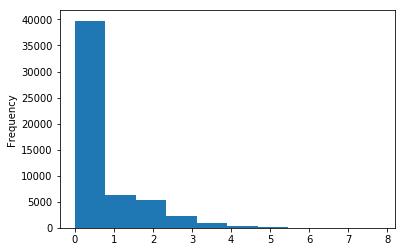

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [8]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


We will only consider the reviewText field. Let's fill-in the missing values for that below. We will just use the placeholder "Missing" here.

In [9]:
df["reviewText"].fillna("Missing", inplace=True)

### 3. Train-validation split

Let's split the dataset into training and validation

In [10]:
# This separates 15% of the entire dataset into validation dataset.
train_text, val_text, train_label, val_label = \
    train_test_split(df["reviewText"].tolist(),
                     df["log_votes"].tolist(),
                     test_size=0.15,
                     random_state=42)

### 4. Text processing and Transformation
We will apply the following processes here:
* __Text cleaning:__ Simple text cleaning operations. We won't do stemming or lemmatization as our word vectors already cover different forms of words. We are using GloVe word embeddings for 6 billion words, phrases or punctuations in this example.
* __Tokenization:__ Tokenizing all sentences
* __Creating vocabulary:__ We will create a vocabulary of the tokens. In this vocabulary, tokens will map to unique ids, such as "car"->32, "house"->651, etc.
* __Transforming text:__ Tokenized sentences will be mapped to unique ids. For example: ["this", "is", "sentence"] -> [13, 54, 412].

In [11]:
import nltk, gluonnlp
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def cleanStr(text):
    # Remove leading/trailing whitespace
    text = text.lower().strip()
    # Remove extra space and tabs
    text = re.sub('\s+', ' ', text)
    # Remove HTML tags/markups
    text = re.compile('<.*?>').sub('', text)
    return text

def tokenize(text):
    tokens = []
    text = cleanStr(text)
    words = word_tokenize(text)
    for word in words:
        tokens.append(word)
    return tokens

def createVocabulary(text_list, min_freq):
    all_tokens = []
    for sentence in text_list:
        all_tokens += tokenize(sentence)
    # Calculate token frequencies
    counter = gluonnlp.data.count_tokens(all_tokens)
    # Create the vocabulary
    vocab = gluonnlp.Vocab(counter,
                           min_freq = min_freq,
                           unknown_token = '<unk>',
                           padding_token = None,
                           bos_token = None,
                           eos_token = None)
    
    return vocab

def transformText(text, vocab, max_length):
    token_arr = np.zeros((max_length,))
    tokens = tokenize(text)[0:max_length]
    for idx, token in enumerate(tokens):
        try:
            # Use the vocabulary index of the token
            token_arr[idx] = vocab.token_to_idx[token]
        except:
            token_arr[idx] = 0 # Unknown word
    return token_arr

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/optimizer/optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In order to keep the training time low, we only consider the first 250 words (max_length) in sentences. We also only use words that occur more than 5 times in the all sentences (min_freq).

In [12]:
min_freq = 5
max_length = 250

print("Creating the vocabulary")
vocab = createVocabulary(train_text, min_freq)
print("Transforming training texts")
train_text_transformed = nd.array([transformText(text, vocab, max_length) for text in train_text])
print("Transforming validation texts")
val_text_transformed = nd.array([transformText(text, vocab, max_length) for text in val_text])

Creating the vocabulary
Transforming training texts
Transforming validation texts


Let's see some unique ids for some words.

In [13]:
print("Vocabulary index for computer:", vocab['computer'])
print("Vocabulary index for beautiful:", vocab['beautiful'])
print("Vocabulary index for code:", vocab['code'])

Vocabulary index for computer: 67
Vocabulary index for beautiful: 2033
Vocabulary index for code: 421


### 5. Using pre-trained GloVe Word Embeddings:

In this example, we will use GloVe word vectors. `'glove.6B.50d.txt'` file gives us 6 billion words/phrases vectors. Each word vector has 50 numbers in it. The following code shows how to get the word vectors and create an embedding matrix from them. We will connect our vocabulary indexes to the GloVe embedding with the `get_vecs_by_tokens()` function.

In [14]:
from mxnet.contrib import text
glove = text.embedding.create('glove',
                              pretrained_file_name = 'glove.6B.50d.txt')
embedding_matrix = glove.get_vecs_by_tokens(vocab.idx_to_token)

### 6. Training and validation

We have processed our text data and also created our embedding matrixes from GloVe. Now, it is time to start the training process.

We will set our parameters below

In [15]:
# Size of the state vectors
hidden_size = 12

# General NN training parameters
learning_rate = 0.01
epochs = 5
batch_size = 32

# Embedding vector and vocabulary sizes
num_embed = 50 # glove.6B.50d.txt
vocab_size = len(vocab.token_to_idx.keys())

We need to put our data into correct format before the process.

In [16]:
from mxnet.gluon.data import ArrayDataset, DataLoader

train_label = nd.array(train_label)
val_label = nd.array(val_label)

train_dataset = ArrayDataset(train_text_transformed, train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

Our sequential model is made of these layers:
* Embedding layer: This is where our words/tokens are mapped to word vectors.
* RNN layer: We will be using a simple RNN model. We won't stack RNN units in this example. It uses a sinle RNN unit with its hidden state size of 12. More details about the RNN is available [here](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/rnn/index.html#mxnet.gluon.rnn.RNN).
* Dense layer: A dense layer with a single neuron is used to output our log_votes prediction.

In [17]:
context = mx.cpu()

model = nn.Sequential()
model.add(nn.Embedding(vocab_size, num_embed), # Embedding layer
          rnn.RNN(hidden_size, num_layers=1),  # Recurrent layer
          nn.Dense(1))                         # Output layer

Let's initialize this network. Then, we will need to make the embedding layer use our GloVe word vectors.

In [18]:
# Initialize networks parameters
model.collect_params().initialize(mx.init.Xavier(), ctx=context)

# We set the embedding layer's parameters from GloVe
model[0].weight.set_data(embedding_matrix.as_in_context(context))
# We won't change/train the embedding layer
model[0].collect_params().setattr('grad_req', 'null')

We will define the trainer and loss function below. L2 loss is used as this is a regression problem.
$$
\mathrm{L2 loss} = \frac{1}{2} \sum_{i}(label_i - prediction_i)^2
$$

In [19]:
# Setting our trainer
trainer = Trainer(model.collect_params(),
                        'sgd',
                        {'learning_rate': learning_rate})

# We will use L2 loss
l2_loss = L2Loss() 

Now, it is time to start the training process. We will print the L2 loss after each epoch.

In [21]:
import time
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = model(data)
            L = l2_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    # Calculate validation loss
    val_predictions = model(val_text_transformed.as_in_context(context))
    val_loss = nd.sum(l2_loss(val_predictions, val_label)).asscalar()
    
    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.362745 Validation_loss 0.378338 Seconds 9.538171
Epoch 1. Train_loss 0.343267 Validation_loss 0.377031 Seconds 9.300172
Epoch 2. Train_loss 0.335926 Validation_loss 0.377808 Seconds 9.258245
Epoch 3. Train_loss 0.330750 Validation_loss 0.379085 Seconds 9.378384
Epoch 4. Train_loss 0.326565 Validation_loss 0.380351 Seconds 9.146582
